In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


2022-07-22 13:39:06.151101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-22 13:39:06.151191: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/galah92/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
experiments_path = Path.cwd() / 'csv' / 'experiments.csv'
exp_df = pd.read_csv(experiments_path)
exp_df.head()


,exp_path,liquid_type,voltage,crop_base,profile
0,/home/galah92/playground-voltage/Machine Learn...,W,100,230,/home/galah92/playground-voltage/csv/profile_0...
1,/home/galah92/playground-voltage/Machine Learn...,W,1000,230,/home/galah92/playground-voltage/csv/profile_1...
2,/home/galah92/playground-voltage/Machine Learn...,W,150,230,/home/galah92/playground-voltage/csv/profile_2...
3,/home/galah92/playground-voltage/Machine Learn...,W,200,230,/home/galah92/playground-voltage/csv/profile_3...
4,/home/galah92/playground-voltage/Machine Learn...,W,250,230,/home/galah92/playground-voltage/csv/profile_4...


In [3]:
profiles = [np.load(profile_path) for profile_path in exp_df['profile']]
labels = np.vstack(profiles)
f'{labels.nbytes // 1024**2}MB'


'198MB'

In [4]:
# create a features DataFrame and labels numpy array

profile_num_frames = np.array([profile.shape[0] for profile in profiles])
features_dfs = []
for i, num_frames in enumerate(profile_num_frames):
    df = pd.DataFrame({
        'time': np.arange(num_frames),
        'voltage': exp_df.loc[i]['voltage'],
        'liquid_type': exp_df.loc[i]['liquid_type']
    })
    features_dfs.append(df)


features_df = pd.concat(features_dfs, axis=0)
labels.shape, len(features_df)


((25358, 1024), 25358)

In [52]:
def create_features_dict(features, categorical_feature_names):
    inputs = {}
    for name, dtype in features_df.dtypes.to_dict().items():
        if dtype == object:
            inputs[name] = tf.keras.layers.Input(shape=(), dtype=tf.string)
        elif name in categorical_feature_names:
            inputs[name] = tf.keras.layers.Input(shape=(), dtype=tf.int64)
        else:
            inputs[name] = tf.keras.layers.Input(shape=(), dtype=tf.float32)
    return inputs


def create_preprocess_model(inputs, features, labels):
    def stack_dict(inputs, fun=tf.stack):
        values = []
        for key in sorted(inputs.keys()):
            values.append(tf.cast(inputs[key], tf.float32))

        return fun(values, axis=-1)

    preprocessed = []

    feature_names = set(inputs.keys())
    numeric_feature_names = set([name
                                 for name in feature_names
                                 if inputs[name].dtype == tf.float32])
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(stack_dict(dict(features[numeric_feature_names])))
    numeric_inputs = {name: inputs[name]
                      for name in inputs
                      if inputs[name].dtype == tf.float32}
    numeric_inputs = stack_dict(numeric_inputs)
    numeric_normalized = normalizer(numeric_inputs)

    preprocessed.append(numeric_normalized)

    categorical_feature_names = feature_names - numeric_feature_names
    for name in categorical_feature_names:
        vocab = features[name].unique()
        if type(vocab[0]) is str:
            lookup = tf.keras.layers.StringLookup(
                vocabulary=vocab, output_mode='one_hot')
        else:
            lookup = tf.keras.layers.IntegerLookup(
                vocabulary=vocab, output_mode='one_hot')

        x = inputs[name][:, tf.newaxis]
        x = lookup(x)
        preprocessed.append(x)

    preprocesssed_result = tf.concat(preprocessed, axis=-1)
    preprocessor = tf.keras.Model(inputs, preprocesssed_result)
    return preprocessor


def prepend_preprocessor(inputs, preprocessor, model):
    intermediate = preprocessor(inputs)
    output = model(intermediate)
    model = tf.keras.Model(inputs, output)
    return model


In [110]:
ds = tf.data.Dataset.from_tensor_slices((dict(features_df), labels))
ds_len = ds.cardinality().numpy()
ds = ds.shuffle(ds_len)
ds = ds.batch(128)

test_ds, train_ds = ds.take(16), ds.skip(16)
val_ds, train_ds = train_ds.take(16), train_ds.skip(16)

ds_card = ds.cardinality().numpy()
test_ds_card = test_ds.cardinality().numpy()
train_ds_card = train_ds.cardinality().numpy()
val_ds_card = val_ds.cardinality().numpy()
print(f'{train_ds_card} + {val_ds_card} + {test_ds_card} = {ds_card}')
# train_ds = train_ds.repeat()


167 + 16 + 16 = 199


In [111]:
categorical_feature_names = ['liquid_type']
input_dict = create_features_dict(features_df, categorical_feature_names)
preprocessor = create_preprocess_model(input_dict, features_df, labels)


In [112]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(labels.shape[-1])
])

model = prepend_preprocessor(input_dict, preprocessor, model)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_ds, epochs=300, validation_data=val_ds)


Epoch 1/300
167/167 [==============================] - 2s 9ms/step - loss: 0.0517 - val_loss: 0.0266
Epoch 2/300
167/167 [==============================] - 2s 10ms/step - loss: 0.0261 - val_loss: 0.0214
Epoch 3/300
167/167 [==============================] - 1s 8ms/step - loss: 0.0220 - val_loss: 0.0192
Epoch 4/300
167/167 [==============================] - 2s 9ms/step - loss: 0.0197 - val_loss: 0.0178
Epoch 5/300
167/167 [==============================] - 2s 9ms/step - loss: 0.0184 - val_loss: 0.0162
Epoch 6/300
167/167 [==============================] - 2s 9ms/step - loss: 0.0176 - val_loss: 0.0141
Epoch 7/300
167/167 [==============================] - 2s 9ms/step - loss: 0.0170 - val_loss: 0.0142
Epoch 8/300
167/167 [==============================] - 2s 9ms/step - loss: 0.0164 - val_loss: 0.0139
Epoch 9/300
167/167 [==============================] - 2s 9ms/step - loss: 0.0160 - val_loss: 0.0140
Epoch 10/300
167/167 [==============================] - 2s 9ms/step - loss: 0.0157 - val_l

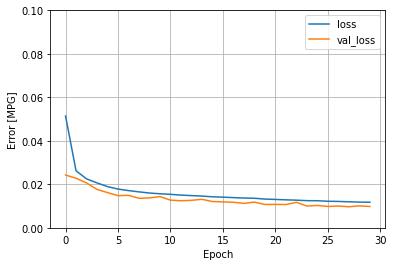

In [102]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)


plot_loss(history)


In [103]:
y_pred = model.predict(test_ds)
y_test = np.concatenate([y for x, y in test_ds], axis=0)


16/16 [==============================] - 0s 9ms/step


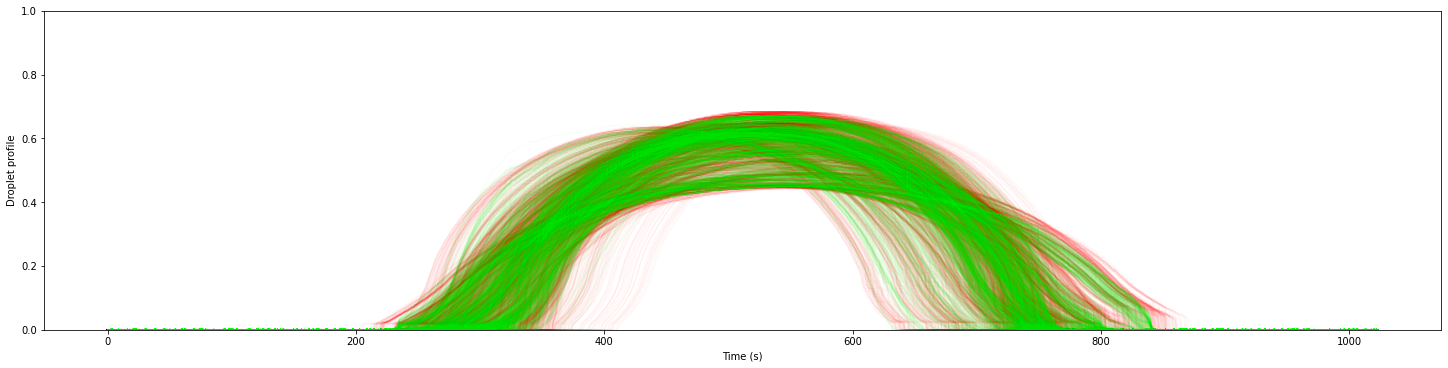

In [104]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5), constrained_layout=True)
_ = axes.plot(y_test.T, color="#ff000008")
_ = axes.plot(y_pred.T, color="#00ff0008")
_ = axes.set_xlabel("Time (s)")
_ = axes.set_ylabel("Droplet profile")
_ = axes.set_ylim(0, 1)
